In [ ]:
! pip install pyhht

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy as np

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


In [ ]:
# Mengakses lokasi penyimpanan berkas pada Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from pyhht.emd import EMD
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
def plot_imfs(signal, imfs, time_samples=None, fignum=None):
    if time_samples is None:
        time_samples = np.arange(signal.shape[0])

    n_imfs = imfs.shape[0]

    plt.figure(num=fignum, figsize=(16, 25))
    axis_extent = max(np.max(np.abs(imfs[:-1, :]), axis=0))

    # Plot original signal
    ax = plt.subplot(n_imfs + 1, 1, 1)
    ax.plot(time_samples, signal)
    ax.axis([time_samples[0], time_samples[-1], signal.min(), signal.max()])
    ax.tick_params(which='both')
    ax.grid(True)
    ax.set_ylabel('Signal')
    ax.set_title('Empirical Mode Decomposition')

    # Plot the IMFs
    for i in range(n_imfs - 1):
        print(i + 2)
        ax = plt.subplot(n_imfs + 1, 1, i + 2)
        ax.plot(time_samples, imfs[i, :])
        ax.axis([time_samples[0], time_samples[-1], -axis_extent, axis_extent])
        ax.tick_params(which='both')
        ax.grid(True)
        ax.set_ylabel('imf' + str(i + 1))
    
    plt.show()
    plt.close()

    plt.figure(figsize=(16, 5))
    plt.plot(time_samples, imfs[-1, :], 'r')
    
    plt.axis('tight')
    plt.tick_params(which='both')
    plt.grid(True)
    plt.ylabel('res.')

    line = plt.gca().lines[0]
    xdata = line.get_xdata()
    ydata = line.get_ydata()
    plt.show()

    data_res = pd.DataFrame(index=None)
    data_res["X"] = xdata
    data_res["Y"] = ydata.astype("int64")
    data_res["SIGNAL"] = signal.astype("int64")
    print(data_res)
    data_res.to_csv("data_res.txt", index=None)

In [ ]:
# Menampilkan struktur tabel (baris, kolom, dan tipe data) pada file data
import pandas as pd
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/.../data/new_data_ok.csv", engine="python")[12:]
new_data = data.copy()
new_data["MONTH"] = new_data["MONTH"].astype("datetime64")
new_data = new_data.set_index("MONTH")
bps, trends = new_data.BPS, new_data.TRENDS
new_data.drop(columns=["BPS", "TRENDS", "Unnamed: 0", "DELAY0"], inplace=True)
new_data = new_data.astype("int64")
print(new_data.dtypes)
new_data

DELAY1     int64
DELAY2     int64
DELAY3     int64
DELAY4     int64
DELAY5     int64
DELAY6     int64
DELAY7     int64
DELAY8     int64
DELAY9     int64
DELAY10    int64
DELAY11    int64
DELAY12    int64
dtype: object


,DELAY1,DELAY2,DELAY3,DELAY4,DELAY5,DELAY6,DELAY7,DELAY8,DELAY9,DELAY10,DELAY11,DELAY12
MONTH,,,,,,,,,,,,
2009-01-01,305767,266175,299943,274428,317583,314608,314608,396508,274428,576583,219303,291312
2009-02-01,329623,305767,266175,299943,274428,317583,314608,314608,396508,274428,576583,219303
2009-03-01,302848,329623,305767,266175,299943,274428,317583,314608,314608,396508,274428,576583
2009-04-01,458752,302848,329623,305767,266175,299943,274428,317583,314608,314608,396508,274428
2009-05-01,776223,458752,302848,329623,305767,266175,299943,274428,317583,314608,314608,396508
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,297052,533232,305767,444528,548800,655452,386575,448063,427063,434007,568575,473200
2021-09-01,416752,297052,533232,305767,444528,548800,655452,386575,448063,427063,434007,568575
2021-10-01,544887,416752,297052,533232,305767,444528,548800,655452,386575,448063,427063,434007


# Pembersihan Noise Menggunakan HHT

[ 291312  219303  576583  274428  396508  314608  314608  317583  274428
  299943  266175  305767  329623  302848  458752  776223  681408  592767
  694575  560623  651175  857500  592767  338800  979132  776223  813967
  685783 1228927  540988  506527  707868  529375  576583  406567  862407
  887151  703423  462343  646912  794983  617463 1097712  469567  852606
  887151  707868  685783 1005487  664048  799708  638428  799708  804447
  818747  672700  651175  809200  725788  540988  560623  721287  790272
  690172 1228927 1037575  847728  877212  907200  813967  762300  917308
  818747 1270332 1092175 1103263  927472  892143  872263 1404928  994903
  725788 1312423 1053808 1461943 1037575 1016127 1064700 1182447 1070167
  804447 1223068  867328  942823  963487 1053808 1276303 1081143 1392412
 1108828 1240687  989632 1010800 1153852 1005487 1165248  882175 1417500
 1306368 1205575 1205575 1442812 1639792 1258432 1417500 1820700 1633023
 1361367 1936732 1097712 1792252 1673847 1468348 13

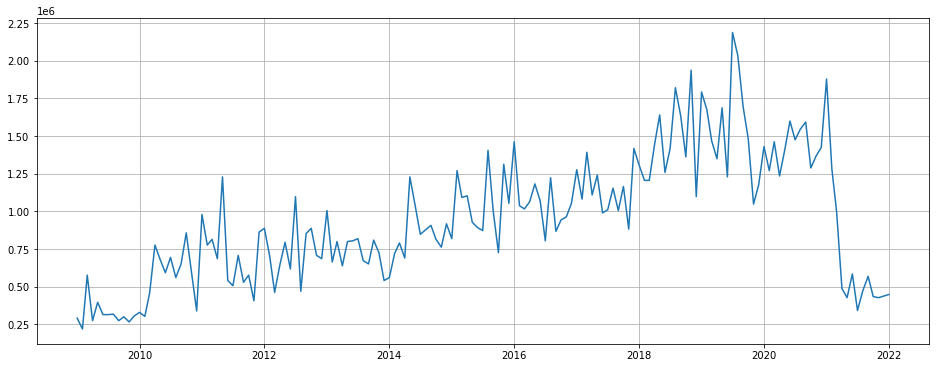

In [ ]:
# Membuat dataset menjadi grafik
line1 = np.array(data["MONTH"].astype("datetime64"))
modes = np.array(new_data["DELAY12"])
print(modes)
plt.figure(figsize=(16, 6))
plt.plot_date(line1, modes, "-")
plt.grid()
plt.show()

2
3
4
5


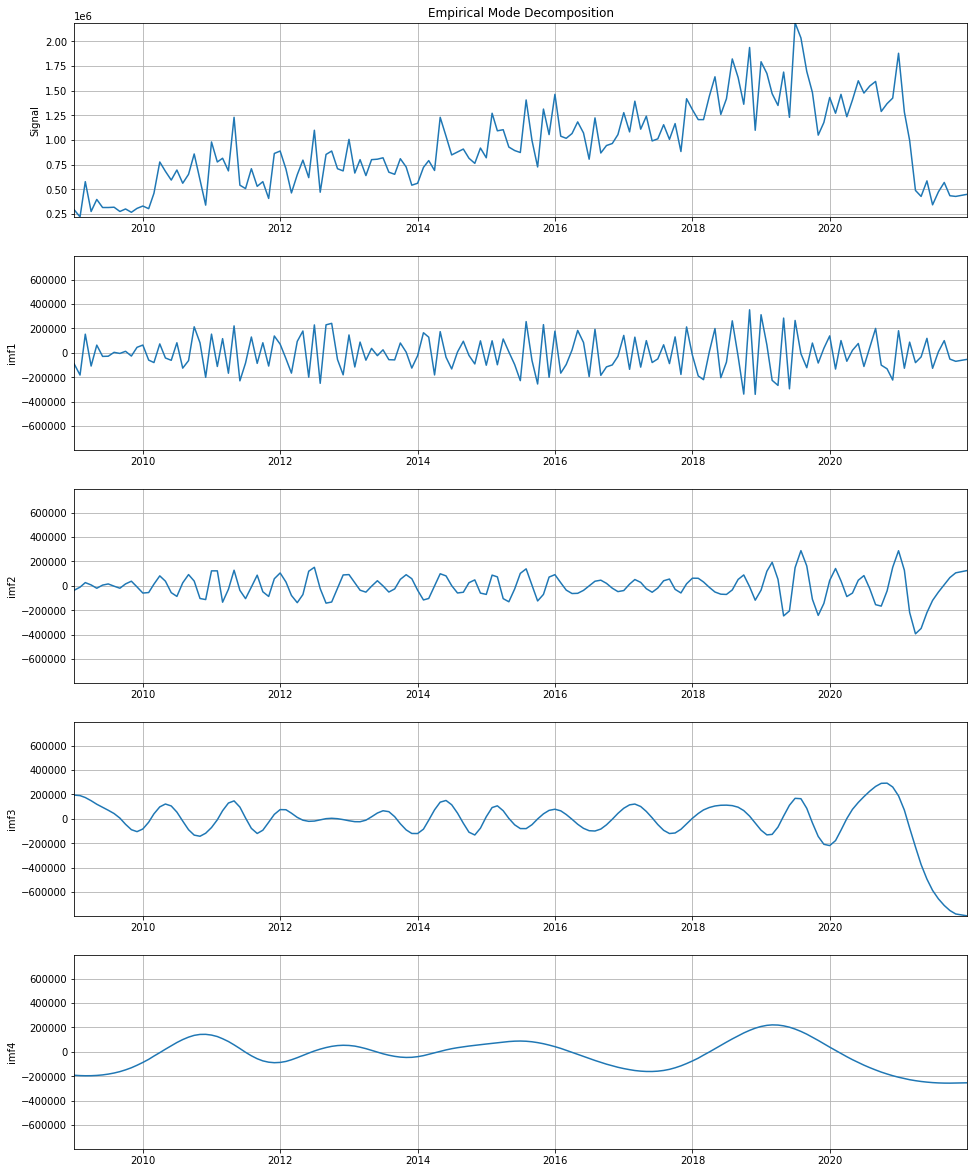

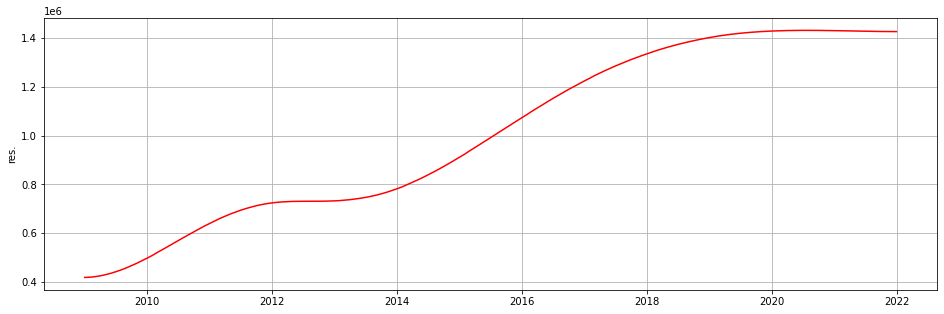

             X        Y  SIGNAL
0   2009-01-01   417831  291312
1   2009-02-01   418780  219303
2   2009-03-01   420960  576583
3   2009-04-01   424360  274428
4   2009-05-01   428912  396508
..         ...      ...     ...
151 2021-08-01  1428295  473200
152 2021-09-01  1427942  568575
153 2021-10-01  1427639  434007
154 2021-11-01  1427394  427063
155 2021-12-31  1427203  448063

[156 rows x 3 columns]


In [ ]:
# Pemprosesan Noise dan Hasil Pembersihan
decompos = EMD(modes)
imfs = decompos.decompose()
plot_imf = plot_imfs(modes, imfs, line1)

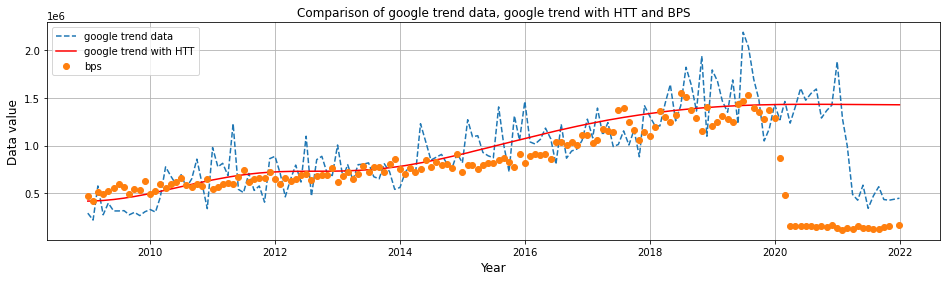

In [ ]:
# Gabungan dataset bps, google trends, dan hht
# GOOGLE TREND Warna Biru
# BPS Warna Oren
# HHT WArna Merah
data_res = pd.read_csv("data_res.txt").set_index(line1)
hht_res = data_res["Y"]
real_signal = data_res["SIGNAL"]
plt.figure(figsize=(16, 4))
plt.plot(real_signal, '--')
plt.plot(hht_res, 'r')
plt.plot(bps, 'o')
#memberi judul table
plt.title('Comparison of google trend data, google trend with HTT and BPS', size='large')
plt.xlabel('Year', size='large')
plt.ylabel('Data value', size='large')
plt.legend(['google trend data','google trend with HTT','bps'])
plt.grid()
plt.show()

In [ ]:
hht_res_big = []
for line in hht_res:
    hht_res_big.append(int(line))

compare = pd.DataFrame([hht_res_big, bps], ["hht", "bps"]).transpose()
compare

,hht,bps
0,417831,473165
1,418780,421555
2,420960,511314
3,424360,487121
4,428912,521735
...,...,...
151,1428295,124751
152,1427942,124071
153,1427639,148645
154,1427394,153199


# Proses Pengujian Atau Prediksi LSTM

In [ ]:
# Selanjutnya Proses Prediski
# Menampilkan struktur tabel (hht, bps, dan bulan)
dataset = compare
bulan = pd.read_csv("/content/drive/My Drive/Colab Notebooks/.../data/new_data_ok.csv", engine="python")[12:].reset_index()
dataset["MONTH"] = bulan["MONTH"].str.replace("-", "")
dataset["MONTH"] = dataset["MONTH"].str[:6]
dataset["REAL"] = modes
dataset

,hht,bps,MONTH,REAL
0,417831,473165,200901,291312
1,418780,421555,200902,219303
2,420960,511314,200903,576583
3,424360,487121,200904,274428
4,428912,521735,200905,396508
...,...,...,...,...
151,1428295,124751,202108,473200
152,1427942,124071,202109,568575
153,1427639,148645,202110,434007
154,1427394,153199,202111,427063


In [ ]:
# Memanggil data Tahun 2021
sample = dataset.drop(columns=["bps","REAL"]).astype("int32")
sample1 = dataset.drop(columns=["bps","hht"]).astype("int32")
value = dataset["bps"].astype("int32")
sample_train = np.array(sample[:144]).reshape(len(sample[:144]), 2)
sample_train1 = np.array(sample1[:144]).reshape(len(sample1[:144]), 2)
value_train = np.array(value[:144])
sample_test = np.array(sample[144:]).reshape(len(sample[144:]), 2)
sample_test1 = np.array(sample1[144:]).reshape(len(sample1[144:]), 2)
value_test = np.array(value[144:])
print(sample_test)
print(value_test)

[[1431217  202101]
 [1430830  202102]
 [1430414  202103]
 [1429981  202104]
 [1429541  202105]
 [1429105  202106]
 [1428686  202107]
 [1428295  202108]
 [1427942  202109]
 [1427639  202110]
 [1427394  202111]
 [1427203  202112]]
[137230 115765 130933 125001 152604 137247 135438 124751 124071 148645
 153199 163619]


In [ ]:
# Membangun arsitektur LSTM Forecasting yang belum di HHT ( TREND )
lstm1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max(sample["hht"]+1), output_dim=100, trainable=False, input_length=2),
    tf.keras.layers.LSTM(100, time_major=True, return_sequences=True, activation="exponential"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="exponential")
], name="LSTM1")

lstm1.compile(optimizer="RMSprop", loss="mean_absolute_percentage_error", metrics=["mean_absolute_percentage_error"])
lstm1.summary()

Model: "LSTM1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2, 100)            143232300 
                                                                 
 lstm (LSTM)                 (None, 2, 100)            80400     
                                                                 
 dense (Dense)               (None, 2, 1)              101       
                                                                 
 flatten (Flatten)           (None, 2)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 143,312,804
Trainable params: 80,504
Non-trainable params: 143,232,300
_________________________________________________________________


In [ ]:
#Proses pelatihan LSTM Forecasting untuk data latih sekaligus melakukan validasi terhadap data uji yang belum di HHT ( TREND )
lstm1.fit(sample_train1, value_train, batch_size=1, epochs=50, verbose=1, shuffle=False, use_multiprocessing=True)

Epoch 1/50
 84/144 [================>.............] - ETA: 0s - loss: 69.7321 - mean_absolute_percentage_error: 69.7321

InvalidArgumentError: ignored

In [ ]:
#pelatihan dengan epoch 100
lstm1.fit(sample_train1, value_train, batch_size=1, epochs=100, verbose=1, shuffle=False, use_multiprocessing=True)

Epoch 1/100
144/144 [==============================] - 1s 4ms/step - loss: 23.1163 - mean_absolute_percentage_error: 23.1163
Epoch 2/100
144/144 [==============================] - 1s 4ms/step - loss: 22.8615 - mean_absolute_percentage_error: 22.8615
Epoch 3/100
144/144 [==============================] - 1s 4ms/step - loss: 23.0855 - mean_absolute_percentage_error: 23.0855
Epoch 4/100
144/144 [==============================] - 1s 4ms/step - loss: 24.4832 - mean_absolute_percentage_error: 24.4832
Epoch 5/100
144/144 [==============================] - 1s 4ms/step - loss: 22.5596 - mean_absolute_percentage_error: 22.5596
Epoch 6/100
144/144 [==============================] - 1s 4ms/step - loss: 23.3809 - mean_absolute_percentage_error: 23.3809
Epoch 7/100
144/144 [==============================] - 1s 4ms/step - loss: 23.8392 - mean_absolute_percentage_error: 23.8392
Epoch 8/100
144/144 [==============================] - 1s 4ms/step - loss: 22.1334 - mean_absolute_percentage_error: 22.1334


In [ ]:
#pelatihan dengan epoch 150
lstm1.fit(sample_train1, value_train, batch_size=1, epochs=150, verbose=1, shuffle=False, use_multiprocessing=True)

Epoch 1/150
144/144 [==============================] - 1s 4ms/step - loss: 20.0686 - mean_absolute_percentage_error: 20.0686
Epoch 2/150
144/144 [==============================] - 1s 4ms/step - loss: 18.9912 - mean_absolute_percentage_error: 18.9912
Epoch 3/150
144/144 [==============================] - 1s 4ms/step - loss: 21.3605 - mean_absolute_percentage_error: 21.3605
Epoch 4/150
144/144 [==============================] - 1s 4ms/step - loss: 20.6517 - mean_absolute_percentage_error: 20.6517
Epoch 5/150
144/144 [==============================] - 1s 4ms/step - loss: 19.3398 - mean_absolute_percentage_error: 19.3398
Epoch 6/150
144/144 [==============================] - 1s 4ms/step - loss: 18.8012 - mean_absolute_percentage_error: 18.8012
Epoch 7/150
144/144 [==============================] - 1s 4ms/step - loss: 18.7083 - mean_absolute_percentage_error: 18.7083
Epoch 8/150
144/144 [==============================] - 1s 4ms/step - loss: 20.4566 - mean_absolute_percentage_error: 20.4566


In [ ]:
#pelatihan dengan epoch 200
lstm1.fit(sample_train1, value_train, batch_size=1, epochs=200, verbose=1, shuffle=False, use_multiprocessing=True)

Epoch 1/200
144/144 [==============================] - 1s 4ms/step - loss: 13.1149 - mean_absolute_percentage_error: 13.1149
Epoch 2/200
144/144 [==============================] - 1s 4ms/step - loss: 13.8134 - mean_absolute_percentage_error: 13.8134
Epoch 3/200
144/144 [==============================] - 1s 4ms/step - loss: 12.8720 - mean_absolute_percentage_error: 12.8720
Epoch 4/200
144/144 [==============================] - 1s 4ms/step - loss: 12.4693 - mean_absolute_percentage_error: 12.4693
Epoch 5/200
144/144 [==============================] - 1s 4ms/step - loss: 13.5280 - mean_absolute_percentage_error: 13.5280
Epoch 6/200
144/144 [==============================] - 1s 4ms/step - loss: 14.0816 - mean_absolute_percentage_error: 14.0816
Epoch 7/200
144/144 [==============================] - 1s 4ms/step - loss: 13.3689 - mean_absolute_percentage_error: 13.3689
Epoch 8/200
144/144 [==============================] - 1s 4ms/step - loss: 13.9457 - mean_absolute_percentage_error: 13.9457


In [ ]:
#pelatihan dengan epoch 250
lstm1.fit(sample_train1, value_train, batch_size=1, epochs=250, verbose=1, shuffle=False, use_multiprocessing=True)

Epoch 1/250
144/144 [==============================] - 1s 4ms/step - loss: 12.6444 - mean_absolute_percentage_error: 12.6444
Epoch 2/250
144/144 [==============================] - 1s 4ms/step - loss: 11.9226 - mean_absolute_percentage_error: 11.9226
Epoch 3/250
144/144 [==============================] - 1s 4ms/step - loss: 12.7862 - mean_absolute_percentage_error: 12.7862
Epoch 4/250
144/144 [==============================] - 1s 4ms/step - loss: 10.8606 - mean_absolute_percentage_error: 10.8606
Epoch 5/250
144/144 [==============================] - 1s 4ms/step - loss: 11.4689 - mean_absolute_percentage_error: 11.4689
Epoch 6/250
144/144 [==============================] - 1s 4ms/step - loss: 11.2836 - mean_absolute_percentage_error: 11.2836
Epoch 7/250
144/144 [==============================] - 1s 4ms/step - loss: 11.8615 - mean_absolute_percentage_error: 11.8615
Epoch 8/250
144/144 [==============================] - 1s 4ms/step - loss: 11.1948 - mean_absolute_percentage_error: 11.1948


In [ ]:
#pelatihan dengan epoch 300
lstm1.fit(sample_train1, value_train, batch_size=1, epochs=300, verbose=1, shuffle=False, use_multiprocessing=True)

Epoch 1/300
144/144 [==============================] - 1s 4ms/step - loss: 8.7455 - mean_absolute_percentage_error: 8.7455
Epoch 2/300
144/144 [==============================] - 1s 4ms/step - loss: 15.2510 - mean_absolute_percentage_error: 15.2510
Epoch 3/300
144/144 [==============================] - 1s 4ms/step - loss: 8.1986 - mean_absolute_percentage_error: 8.1986
Epoch 4/300
144/144 [==============================] - 1s 4ms/step - loss: 11.4425 - mean_absolute_percentage_error: 11.4425
Epoch 5/300
144/144 [==============================] - 1s 4ms/step - loss: 9.3177 - mean_absolute_percentage_error: 9.3177
Epoch 6/300
144/144 [==============================] - 1s 4ms/step - loss: 24.9348 - mean_absolute_percentage_error: 24.9348
Epoch 7/300
144/144 [==============================] - 1s 4ms/step - loss: 8.0289 - mean_absolute_percentage_error: 8.0289
Epoch 8/300
144/144 [==============================] - 1s 4ms/step - loss: 9.8081 - mean_absolute_percentage_error: 9.8081
Epoch 9/30

In [ ]:
#pelatihan dengan epoch 350
lstm1.fit(sample_train1, value_train, batch_size=1, epochs=350, verbose=1, shuffle=False, use_multiprocessing=True)

Epoch 1/350
144/144 [==============================] - 4s 4ms/step - loss: 97.4991 - mean_absolute_percentage_error: 97.4991
Epoch 2/350
144/144 [==============================] - 1s 4ms/step - loss: 33.7586 - mean_absolute_percentage_error: 33.7586
Epoch 3/350
144/144 [==============================] - 1s 4ms/step - loss: 29.9786 - mean_absolute_percentage_error: 29.9786
Epoch 4/350
144/144 [==============================] - 1s 4ms/step - loss: 31.1383 - mean_absolute_percentage_error: 31.1383
Epoch 5/350
144/144 [==============================] - 1s 4ms/step - loss: 30.8495 - mean_absolute_percentage_error: 30.8495
Epoch 6/350
144/144 [==============================] - 1s 4ms/step - loss: 25.2027 - mean_absolute_percentage_error: 25.2027
Epoch 7/350
144/144 [==============================] - 1s 4ms/step - loss: 26.2091 - mean_absolute_percentage_error: 26.2091
Epoch 8/350
144/144 [==============================] - 1s 4ms/step - loss: 29.4655 - mean_absolute_percentage_error: 29.4655


In [ ]:
#pelatihan dengan epoch 400
lstm1.fit(sample_train1, value_train, batch_size=1, epochs=400, verbose=1, shuffle=False, use_multiprocessing=True)

Epoch 1/400
144/144 [==============================] - 1s 4ms/step - loss: 21.9810 - mean_absolute_percentage_error: 21.9810
Epoch 2/400
144/144 [==============================] - 1s 4ms/step - loss: 21.8456 - mean_absolute_percentage_error: 21.8456
Epoch 3/400
144/144 [==============================] - 1s 4ms/step - loss: 21.8328 - mean_absolute_percentage_error: 21.8328
Epoch 4/400
144/144 [==============================] - 1s 4ms/step - loss: 21.1328 - mean_absolute_percentage_error: 21.1328
Epoch 5/400
144/144 [==============================] - 1s 4ms/step - loss: 20.3983 - mean_absolute_percentage_error: 20.3983
Epoch 6/400
144/144 [==============================] - 1s 4ms/step - loss: 21.3115 - mean_absolute_percentage_error: 21.3115
Epoch 7/400
144/144 [==============================] - 1s 4ms/step - loss: 22.0275 - mean_absolute_percentage_error: 22.0275
Epoch 8/400
144/144 [==============================] - 1s 4ms/step - loss: 19.8723 - mean_absolute_percentage_error: 19.8723


In [ ]:
#pelatihan dengan epoch 450
lstm1.fit(sample_train1, value_train, batch_size=1, epochs=450, verbose=1, shuffle=False, use_multiprocessing=True)

Epoch 1/450
144/144 [==============================] - 1s 4ms/step - loss: 17.3025 - mean_absolute_percentage_error: 17.3025
Epoch 2/450
144/144 [==============================] - 1s 4ms/step - loss: 22.9721 - mean_absolute_percentage_error: 22.9721
Epoch 3/450
144/144 [==============================] - 1s 4ms/step - loss: 17.0473 - mean_absolute_percentage_error: 17.0473
Epoch 4/450
144/144 [==============================] - 1s 4ms/step - loss: 54.5060 - mean_absolute_percentage_error: 54.5060
Epoch 5/450
144/144 [==============================] - 1s 4ms/step - loss: 16.3740 - mean_absolute_percentage_error: 16.3740
Epoch 6/450
144/144 [==============================] - 1s 4ms/step - loss: 24.8830 - mean_absolute_percentage_error: 24.8830
Epoch 7/450
144/144 [==============================] - 1s 4ms/step - loss: 16.6315 - mean_absolute_percentage_error: 16.6315
Epoch 8/450
144/144 [==============================] - 1s 4ms/step - loss: 17.1493 - mean_absolute_percentage_error: 17.1493


In [ ]:
#pelatihan dengan epoch 500
lstm1.fit(sample_train1, value_train, batch_size=1, epochs=500, verbose=1, shuffle=False, use_multiprocessing=True)

Epoch 1/500
144/144 [==============================] - 1s 4ms/step - loss: 21.0905 - mean_absolute_percentage_error: 21.0905
Epoch 2/500
144/144 [==============================] - 1s 4ms/step - loss: 20.0760 - mean_absolute_percentage_error: 20.0760
Epoch 3/500
144/144 [==============================] - 1s 4ms/step - loss: 20.3171 - mean_absolute_percentage_error: 20.3171
Epoch 4/500
144/144 [==============================] - 1s 4ms/step - loss: 21.2569 - mean_absolute_percentage_error: 21.2569
Epoch 5/500
144/144 [==============================] - 1s 4ms/step - loss: 22.5789 - mean_absolute_percentage_error: 22.5789
Epoch 6/500
144/144 [==============================] - 1s 4ms/step - loss: 21.6331 - mean_absolute_percentage_error: 21.6331
Epoch 7/500
144/144 [==============================] - 1s 4ms/step - loss: 19.6545 - mean_absolute_percentage_error: 19.6545
Epoch 8/500
144/144 [==============================] - 1s 4ms/step - loss: 22.9682 - mean_absolute_percentage_error: 22.9682


In [ ]:
#pelatihan dengan epoch 550
lstm1.fit(sample_train1, value_train, batch_size=1, epochs=550, verbose=1, shuffle=False, use_multiprocessing=True)

Epoch 1/550
144/144 [==============================] - 1s 4ms/step - loss: nan - mean_absolute_percentage_error: nan
Epoch 2/550
144/144 [==============================] - 1s 4ms/step - loss: nan - mean_absolute_percentage_error: nan
Epoch 3/550
144/144 [==============================] - 1s 4ms/step - loss: nan - mean_absolute_percentage_error: nan
Epoch 4/550
144/144 [==============================] - 1s 4ms/step - loss: nan - mean_absolute_percentage_error: nan
Epoch 5/550
144/144 [==============================] - 1s 4ms/step - loss: nan - mean_absolute_percentage_error: nan
Epoch 6/550
144/144 [==============================] - 1s 4ms/step - loss: nan - mean_absolute_percentage_error: nan
Epoch 7/550
144/144 [==============================] - 1s 4ms/step - loss: nan - mean_absolute_percentage_error: nan
Epoch 8/550
144/144 [==============================] - 1s 4ms/step - loss: nan - mean_absolute_percentage_error: nan
Epoch 9/550
144/144 [==============================] - 1s 4ms/st

In [ ]:
# Membangun arsitektur LSTM Forecasting yang di HHT
lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max(sample["hht"]+1), output_dim=100, trainable=False, input_length=2),
    tf.keras.layers.LSTM(100, time_major=True, return_sequences=True, activation="exponential"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="exponential")
], name="LSTM")

lstm.compile(optimizer="RMSprop", loss="mean_absolute_percentage_error", metrics=["mean_absolute_percentage_error"])
lstm.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2, 100)            143232300 
                                                                 
 lstm (LSTM)                 (None, 2, 100)            80400     
                                                                 
 dense (Dense)               (None, 2, 1)              101       
                                                                 
 flatten (Flatten)           (None, 2)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 143,312,804
Trainable params: 80,504
Non-trainable params: 143,232,300
_________________________________________________________________


In [ ]:
#Proses pelatihan LSTM Forecasting untuk data latih sekaligus melakukan validasi terhadap data uji yang di HHT
lstm.fit(sample_train, value_train, batch_size=1, epochs=50, verbose=1, shuffle=False, use_multiprocessing=True)

Epoch 1/50
144/144 [==============================] - 2s 4ms/step - loss: 33.4252 - mean_absolute_percentage_error: 33.4252
Epoch 2/50
144/144 [==============================] - 1s 4ms/step - loss: 21.1481 - mean_absolute_percentage_error: 21.1481
Epoch 3/50
144/144 [==============================] - 1s 4ms/step - loss: 24.2434 - mean_absolute_percentage_error: 24.2434
Epoch 4/50
144/144 [==============================] - 1s 4ms/step - loss: 21.8475 - mean_absolute_percentage_error: 21.8475
Epoch 5/50
144/144 [==============================] - 1s 4ms/step - loss: 22.9952 - mean_absolute_percentage_error: 22.9952
Epoch 6/50
144/144 [==============================] - 1s 4ms/step - loss: 21.5805 - mean_absolute_percentage_error: 21.5805
Epoch 7/50
144/144 [==============================] - 1s 4ms/step - loss: 21.7264 - mean_absolute_percentage_error: 21.7264
Epoch 8/50
144/144 [==============================] - 1s 4ms/step - loss: 21.5092 - mean_absolute_percentage_error: 21.5092
Epoch 9/

In [ ]:
#Proses pelatihan LSTM Forecasting untuk epoch 100
lstm.fit(sample_train, value_train, batch_size=1, epochs=100, verbose=1, shuffle=False, use_multiprocessing=True)

Epoch 1/100
144/144 [==============================] - 1s 4ms/step - loss: 25.7184 - mean_absolute_percentage_error: 25.7184
Epoch 2/100
144/144 [==============================] - 1s 4ms/step - loss: 23.2941 - mean_absolute_percentage_error: 23.2941
Epoch 3/100
144/144 [==============================] - 1s 4ms/step - loss: 23.8673 - mean_absolute_percentage_error: 23.8673
Epoch 4/100
144/144 [==============================] - 1s 4ms/step - loss: 22.6541 - mean_absolute_percentage_error: 22.6541
Epoch 5/100
144/144 [==============================] - 1s 4ms/step - loss: 24.9706 - mean_absolute_percentage_error: 24.9706
Epoch 6/100
144/144 [==============================] - 1s 4ms/step - loss: 25.4324 - mean_absolute_percentage_error: 25.4324
Epoch 7/100
144/144 [==============================] - 1s 4ms/step - loss: 23.8434 - mean_absolute_percentage_error: 23.8434
Epoch 8/100
144/144 [==============================] - 1s 4ms/step - loss: 23.6723 - mean_absolute_percentage_error: 23.6723


In [ ]:
#Proses pelatihan LSTM Forecasting untuk epoch 150
lstm.fit(sample_train, value_train, batch_size=1, epochs=150, verbose=1, shuffle=False, use_multiprocessing=True)

Epoch 1/150
144/144 [==============================] - 1s 6ms/step - loss: 23.2099 - mean_absolute_percentage_error: 23.2099
Epoch 2/150
144/144 [==============================] - 1s 6ms/step - loss: 21.6277 - mean_absolute_percentage_error: 21.6277
Epoch 3/150
144/144 [==============================] - 1s 6ms/step - loss: 21.4730 - mean_absolute_percentage_error: 21.4730
Epoch 4/150
144/144 [==============================] - 1s 6ms/step - loss: 21.3482 - mean_absolute_percentage_error: 21.3482
Epoch 5/150
144/144 [==============================] - 1s 5ms/step - loss: 21.5908 - mean_absolute_percentage_error: 21.5908
Epoch 6/150
144/144 [==============================] - 1s 5ms/step - loss: 22.8466 - mean_absolute_percentage_error: 22.8466
Epoch 7/150
144/144 [==============================] - 1s 5ms/step - loss: 25.1556 - mean_absolute_percentage_error: 25.1556
Epoch 8/150
144/144 [==============================] - 1s 4ms/step - loss: 21.2361 - mean_absolute_percentage_error: 21.2361


In [ ]:
#Proses pelatihan LSTM Forecasting untuk epoch 200
lstm.fit(sample_train, value_train, batch_size=1, epochs=200, verbose=1, shuffle=False, use_multiprocessing=True)

Epoch 1/200
144/144 [==============================] - 1s 4ms/step - loss: 20.1619 - mean_absolute_percentage_error: 20.1619
Epoch 2/200
144/144 [==============================] - 1s 4ms/step - loss: 21.4101 - mean_absolute_percentage_error: 21.4101
Epoch 3/200
144/144 [==============================] - 1s 4ms/step - loss: 20.2609 - mean_absolute_percentage_error: 20.2609
Epoch 4/200
144/144 [==============================] - 1s 4ms/step - loss: 21.8701 - mean_absolute_percentage_error: 21.8701
Epoch 5/200
144/144 [==============================] - 1s 4ms/step - loss: 21.9831 - mean_absolute_percentage_error: 21.9831
Epoch 6/200
144/144 [==============================] - 1s 4ms/step - loss: 20.4611 - mean_absolute_percentage_error: 20.4611
Epoch 7/200
144/144 [==============================] - 1s 4ms/step - loss: 23.0960 - mean_absolute_percentage_error: 23.0960
Epoch 8/200
144/144 [==============================] - 1s 4ms/step - loss: 22.6404 - mean_absolute_percentage_error: 22.6404


In [ ]:
#Proses pelatihan LSTM Forecasting untuk epoch 250
lstm.fit(sample_train, value_train, batch_size=1, epochs=250, verbose=1, shuffle=False, use_multiprocessing=True)

Epoch 1/250
144/144 [==============================] - 1s 4ms/step - loss: 14.0250 - mean_absolute_percentage_error: 14.0250
Epoch 2/250
144/144 [==============================] - 1s 4ms/step - loss: 15.4093 - mean_absolute_percentage_error: 15.4093
Epoch 3/250
144/144 [==============================] - 1s 4ms/step - loss: 14.7593 - mean_absolute_percentage_error: 14.7593
Epoch 4/250
144/144 [==============================] - 1s 4ms/step - loss: 13.9650 - mean_absolute_percentage_error: 13.9650
Epoch 5/250
144/144 [==============================] - 1s 4ms/step - loss: 14.1042 - mean_absolute_percentage_error: 14.1042
Epoch 6/250
144/144 [==============================] - 1s 4ms/step - loss: 13.5267 - mean_absolute_percentage_error: 13.5267
Epoch 7/250
144/144 [==============================] - 1s 4ms/step - loss: 14.3054 - mean_absolute_percentage_error: 14.3054
Epoch 8/250
144/144 [==============================] - 1s 4ms/step - loss: 13.5860 - mean_absolute_percentage_error: 13.5860


In [ ]:
#Proses pelatihan LSTM Forecasting untuk epoch 300
lstm.fit(sample_train, value_train, batch_size=1, epochs=300, verbose=1, shuffle=False, use_multiprocessing=True)

Epoch 1/300
144/144 [==============================] - 1s 3ms/step - loss: 8.9503 - mean_absolute_percentage_error: 8.9503
Epoch 2/300
144/144 [==============================] - 1s 4ms/step - loss: 9.3111 - mean_absolute_percentage_error: 9.3111
Epoch 3/300
144/144 [==============================] - 1s 4ms/step - loss: 9.8873 - mean_absolute_percentage_error: 9.8873
Epoch 4/300
144/144 [==============================] - 1s 4ms/step - loss: 9.9118 - mean_absolute_percentage_error: 9.9118
Epoch 5/300
144/144 [==============================] - 1s 4ms/step - loss: 10.3298 - mean_absolute_percentage_error: 10.3298
Epoch 6/300
144/144 [==============================] - 1s 4ms/step - loss: 9.9133 - mean_absolute_percentage_error: 9.9133
Epoch 7/300
144/144 [==============================] - 1s 4ms/step - loss: 9.1042 - mean_absolute_percentage_error: 9.1042
Epoch 8/300
144/144 [==============================] - 1s 4ms/step - loss: 10.2786 - mean_absolute_percentage_error: 10.2786
Epoch 9/300


In [ ]:
#Proses pelatihan LSTM Forecasting untuk epoch 350
lstm.fit(sample_train, value_train, batch_size=1, epochs=350, verbose=1, shuffle=False, use_multiprocessing=True)

Epoch 1/350
144/144 [==============================] - 2s 4ms/step - loss: 85.2685 - mean_absolute_percentage_error: 85.2685
Epoch 2/350
144/144 [==============================] - 0s 3ms/step - loss: 28.1865 - mean_absolute_percentage_error: 28.1865
Epoch 3/350
144/144 [==============================] - 0s 3ms/step - loss: 24.2332 - mean_absolute_percentage_error: 24.2332
Epoch 4/350
144/144 [==============================] - 0s 3ms/step - loss: 26.0555 - mean_absolute_percentage_error: 26.0555
Epoch 5/350
144/144 [==============================] - 0s 3ms/step - loss: 24.5718 - mean_absolute_percentage_error: 24.5718
Epoch 6/350
144/144 [==============================] - 0s 3ms/step - loss: 20.8031 - mean_absolute_percentage_error: 20.8031
Epoch 7/350
144/144 [==============================] - 0s 3ms/step - loss: 24.6111 - mean_absolute_percentage_error: 24.6111
Epoch 8/350
144/144 [==============================] - 0s 3ms/step - loss: 23.3229 - mean_absolute_percentage_error: 23.3229


In [ ]:
#Proses pelatihan LSTM Forecasting untuk epoch 400
lstm.fit(sample_train, value_train, batch_size=1, epochs=400, verbose=1, shuffle=False, use_multiprocessing=True)

Epoch 1/400
144/144 [==============================] - 1s 4ms/step - loss: 12.5412 - mean_absolute_percentage_error: 12.5412
Epoch 2/400
144/144 [==============================] - 1s 4ms/step - loss: 13.6040 - mean_absolute_percentage_error: 13.6040
Epoch 3/400
144/144 [==============================] - 0s 3ms/step - loss: 14.2411 - mean_absolute_percentage_error: 14.2411
Epoch 4/400
144/144 [==============================] - 0s 3ms/step - loss: 12.9091 - mean_absolute_percentage_error: 12.9091
Epoch 5/400
144/144 [==============================] - 0s 3ms/step - loss: 13.2390 - mean_absolute_percentage_error: 13.2390
Epoch 6/400
144/144 [==============================] - 0s 3ms/step - loss: 13.0085 - mean_absolute_percentage_error: 13.0085
Epoch 7/400
144/144 [==============================] - 0s 3ms/step - loss: 12.8371 - mean_absolute_percentage_error: 12.8371
Epoch 8/400
144/144 [==============================] - 0s 3ms/step - loss: 13.5804 - mean_absolute_percentage_error: 13.5804


In [ ]:
#Proses pelatihan LSTM Forecasting untuk epoch 450
lstm.fit(sample_train, value_train, batch_size=1, epochs=450, verbose=1, shuffle=False, use_multiprocessing=True)

Epoch 1/450
144/144 [==============================] - 0s 3ms/step - loss: 14.8828 - mean_absolute_percentage_error: 14.8828
Epoch 2/450
144/144 [==============================] - 0s 3ms/step - loss: 14.6286 - mean_absolute_percentage_error: 14.6286
Epoch 3/450
144/144 [==============================] - 1s 3ms/step - loss: 271.1577 - mean_absolute_percentage_error: 271.1577
Epoch 4/450
144/144 [==============================] - 0s 3ms/step - loss: 38.3954 - mean_absolute_percentage_error: 38.3954
Epoch 5/450
144/144 [==============================] - 0s 3ms/step - loss: 26.0973 - mean_absolute_percentage_error: 26.0973
Epoch 6/450
144/144 [==============================] - 0s 3ms/step - loss: 16.4257 - mean_absolute_percentage_error: 16.4257
Epoch 7/450
144/144 [==============================] - 0s 3ms/step - loss: 14.2487 - mean_absolute_percentage_error: 14.2487
Epoch 8/450
144/144 [==============================] - 0s 3ms/step - loss: 17.2221 - mean_absolute_percentage_error: 17.222

In [ ]:
#Proses pelatihan LSTM Forecasting untuk epoch 500
lstm.fit(sample_train, value_train, batch_size=1, epochs=500, verbose=1, shuffle=False, use_multiprocessing=True)

Epoch 1/500
144/144 [==============================] - 0s 3ms/step - loss: nan - mean_absolute_percentage_error: nan
Epoch 2/500
144/144 [==============================] - 0s 3ms/step - loss: nan - mean_absolute_percentage_error: nan
Epoch 3/500
144/144 [==============================] - 0s 3ms/step - loss: nan - mean_absolute_percentage_error: nan
Epoch 4/500
144/144 [==============================] - 0s 3ms/step - loss: nan - mean_absolute_percentage_error: nan
Epoch 5/500
144/144 [==============================] - 0s 3ms/step - loss: nan - mean_absolute_percentage_error: nan
Epoch 6/500
144/144 [==============================] - 0s 3ms/step - loss: nan - mean_absolute_percentage_error: nan
Epoch 7/500
144/144 [==============================] - 1s 4ms/step - loss: nan - mean_absolute_percentage_error: nan
Epoch 8/500
144/144 [==============================] - 0s 3ms/step - loss: nan - mean_absolute_percentage_error: nan
Epoch 9/500
144/144 [==============================] - 1s 4ms/st

In [ ]:
# Memprediksi tahun 2021 kemudian menampilkannya yang belum di HHT( TREND )
test_predict1 = lstm1.predict(sample_test1, batch_size=1, use_multiprocessing=True)
predict1 = []
for i in test_predict1:
    predict1.append(i)

predict1

[array([328690.34], dtype=float32),
 array([260914.16], dtype=float32),
 array([288915.56], dtype=float32),
 array([300596.3], dtype=float32),
 array([392300.94], dtype=float32),
 array([478362.03], dtype=float32),
 array([391804.8], dtype=float32),
 array([680068.5], dtype=float32),
 array([905653.06], dtype=float32),
 array([662883.2], dtype=float32),
 array([266865.03], dtype=float32),
 array([150575.56], dtype=float32)]

In [ ]:
# Memprediksi tahun 2021 kemudian menampilkannya yang di HHT
test_predict = lstm.predict(sample_test, batch_size=1, use_multiprocessing=True)
predict = []
for i in test_predict:
    predict.append(i)

predict

[array([326045.34], dtype=float32),
 array([242626.3], dtype=float32),
 array([79916.625], dtype=float32),
 array([321659.44], dtype=float32),
 array([151747.84], dtype=float32),
 array([490376.2], dtype=float32),
 array([131698.56], dtype=float32),
 array([588864.6], dtype=float32),
 array([308904.7], dtype=float32),
 array([198442.48], dtype=float32),
 array([164980.28], dtype=float32),
 array([365812.94], dtype=float32)]

In [ ]:
compare = pd.DataFrame([value_test, predict1, predict], ["ACTUAL", "LSTM", "HHT-LSTM"]).transpose().set_index(line1[-12:])
compare

,ACTUAL,LSTM,HHT-LSTM
2021-01-01,137230,[328690.34],[326045.34]
2021-02-01,115765,[260914.16],[242626.3]
2021-03-01,130933,[288915.56],[79916.625]
2021-04-01,125001,[300596.3],[321659.44]
2021-05-01,152604,[392300.94],[151747.84]
2021-06-01,137247,[478362.03],[490376.2]
2021-07-01,135438,[391804.8],[131698.56]
2021-08-01,124751,[680068.5],[588864.6]
2021-09-01,124071,[905653.06],[308904.7]
2021-10-01,148645,[662883.2],[198442.48]


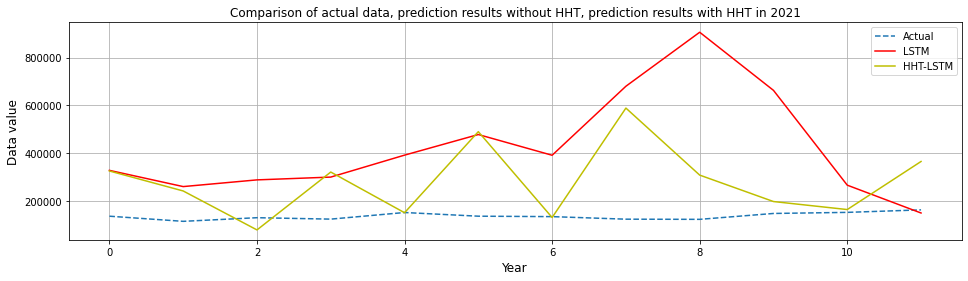

In [ ]:
##coba membuat grafik (wajib ada)
plt.figure(figsize=(16, 4))
plt.plot(value_test, '--')
plt.plot(predict1, 'r')
plt.plot(predict, '-y')
#memberi judul table
plt.title('Comparison of actual data, prediction results without HHT, prediction results with HHT in 2021', size='large')
plt.xlabel('Year', size='large')
plt.ylabel('Data value', size='large')
plt.legend(['Actual','LSTM','HHT-LSTM'])
plt.grid()
plt.show()

In [ ]:
# Hasil RMSE dan MAPE ditahun 2021
mape = []
mape1 = []
rmse = []
rmse1 = []
for i in range(len(sample_test)):
    mape.append((abs((value_test[i] - predict[i]) / value_test[i]) * 100).tolist())
    rmse.append(np.sqrt((value_test[i] - predict[i])**2).tolist())

    mape1.append((abs((value_test[i] - predict1[i]) / value_test[i]) * 100).tolist())
    rmse1.append(np.sqrt((value_test[i] - predict1[i])**2).tolist())

mape1 = [j for sub in mape1 for j in sub]
rmse1 = [j for sub in rmse1 for j in sub]
eval = pd.DataFrame()
eval["MAPE LSTM"] = mape1
eval["RMSE LSTM"] = rmse1

mape = [j for sub in mape for j in sub]
rmse = [j for sub in rmse for j in sub]
eval["MAPE HHT-LSTM"] = mape
eval["RMSE HHT-LSTM"] = rmse

eval

,MAPE LSTM,RMSE LSTM,MAPE HHT-LSTM,RMSE HHT-LSTM
0,139.517849,191460.34375,137.590428,188815.343750
1,125.382591,145149.15625,109.585191,126861.296875
2,120.659087,157982.56250,38.963726,51016.375000
3,140.475126,175595.31250,157.325491,196658.437500
4,157.071202,239696.93750,0.561031,856.156250
5,248.540974,341115.03125,257.294649,353129.187500
6,189.287211,256366.81250,2.760996,3739.437500
7,445.140720,555317.50000,372.031988,464113.625000
8,629.947419,781582.06250,148.974126,184833.687500
9,345.950545,514238.18750,33.500948,49797.484375


In [ ]:
mapea1=np.average(eval['MAPE LSTM'])
rmsea1 = np.average(eval['RMSE LSTM'])
print("MAPE LSTM: ", mapea1)
print("RMSE LSTM: ", rmsea1)

mapea=np.average(eval['MAPE HHT-LSTM'])
rmsea = np.average(eval['RMSE HHT-LSTM'])
print("MAPE HHT-LSTM: ", mapea)
print("RMSE HHT-LSTM: ", rmsea)

MAPE LSTM:  218.67829849117177
RMSE LSTM:  290434.4479166667
MAPE HHT-LSTM:  115.82123586865403
RMSE HHT-LSTM:  152816.35416666666
